In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from functions import drop_rows, remove_outliers

In [2]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
x = data.drop("stroke", axis=1)
y = data["stroke"]

In [3]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1, stratify=y
)

In [4]:
x_train, y_train = drop_rows(x_train, y_train, x_train["gender"] == "Other")
x_train, y_train, outliers = remove_outliers(x_train, y_train, "bmi")
x_test, y_test = drop_rows(x_test, y_test, x_test["gender"] == "Other")
x_test = x_test[x_test["bmi"] < outliers.min()]
y_test = y_test.loc[x_test.index]
ros = RandomOverSampler(random_state=1)
x_train, y_train = ros.fit_resample(x_train, y_train)

We do data cleaning steps first as we won't include them in a pipeline.

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["age", "avg_glucose_level"]),
        ("columns_to_drop", "drop", []),
    ]
)
model = LogisticRegression(
    C=0.01, fit_intercept=True, max_iter=100, penalty="l1", solver="liblinear"
)
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

We're using standard scaler to scale the only columns of interest, and dropping the rest. Also, we're using model hyperparameters we found during training stage. After that we're  combining both in an sklearn pipeline.

              precision    recall  f1-score   support

           0       0.98      0.70      0.81       933
           1       0.11      0.77      0.20        47

    accuracy                           0.70       980
   macro avg       0.55      0.73      0.51       980
weighted avg       0.94      0.70      0.79       980



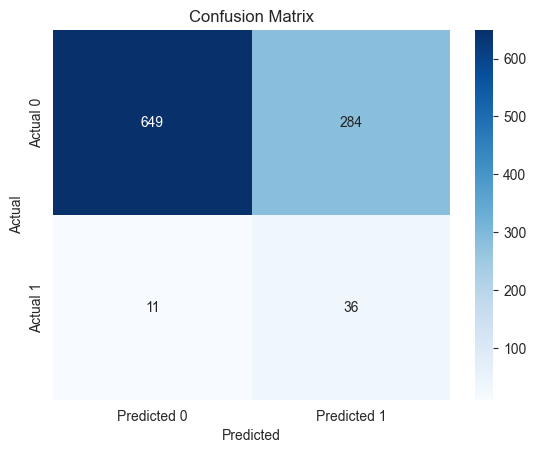

In [6]:
pipeline.fit(x_train, y_train)
preds = pipeline.predict(x_test)
cm = confusion_matrix(y_test, preds)
report = classification_report(y_test, preds)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(report)

We end up getting very similar, but not exactly the same performance, possibly because we didn't split off a validation set. We'll use pickle to turn our model into a file, so that we can later load on to the app or a web service.

In [7]:
with open("logisticregression.pkl", "wb") as file:
    pickle.dump(pipeline, file)

# Conclusions
We have performed extensive EDA, attempted to impute some missing values and trained a few models to predict stroke. To summarize:
* We looked over each of the features, to look for outliers or any other elements that might cause problems in model training stage.
    * Gender, BMI features had some data that we could consider outliers. We ended up dropping them.
    * Work type, smoking status and BMI features had some data, that could be considered problematic.
        * We used KNN to fill in missing values in BMI and attempted to train a few models to check whether we can accurately predict smoking status, however we could not.
        * We ended up merging children category in work type feature with never worked category.
* We looked at the distributions of our features.
    * We saw that we had more women in our dataset.
    * As for distribution of stroke according to age and gender, women of age 70-82 tend to have strokes more often than men, though men tend to have more strokes overall.
    * Rate of stroke tends to increase drastically as people get older.
    * People with hypertension or heart diseases tend to have strokes more often.
    * People with abnormally high glucose levels tend to have strokes more often.
    * There didn't seem to be any relationships between age, average glucose levels and bmi, Exception for a possible non-linear relationship between age and bmi.
    * We saw that married people tend to have strokes more often, though that is due to the reason that with our data, married people tended to be older.
    * We saw that self-employed people tend to have strokes more often, but it's most likely for the same reasons as with married people, they tended to be older.
    * Same with people who formerly smoked.
* We looked at feature importance in XGBoost model and Logistic regression model.
    * Most important feature across all models seemed to be age.
    * In XGBoost all other features seemed to hold very similar, low importance compared to age, with the exceptions of bmi and average glucose level.
    * In Logistic regresssion there were few coefficients with values close to zero.
        * These were generally residence type and gender features.
        * Ever married, work type features had higher coefficients, when compared to XGBoost
* We trained 4 types of models, XGBoost, LightGBM, SVC with different kernels and Logistic regression model.
    * SVC models, specifically with rbf and polynomial kernel performed the worst out of these.
    * XGBoost, LightGBM and Logistic regression models performed better with logistic regression performing best on validation set.
        *  After removing features that didn't have a linear relationship with our target variable and were correlated with other features, the only relevant coefficients were age and average glucose level.
        * After that Logistic regression models' performance increased, and we chose it as the best model with recall of 0.82 on validation set and 0.77 on testing set.
* Overall I'd say that recall of this model is not high enough to be applied in medical setting, also the model is too simple to predict edge cases and with the features we currently have more complex models can't pick up on the patters in data, to have high enough recall.